In [1]:
# The purpose of this file is to run K pod method and other classficiation methods, which deal with the missing data in the dataset
# created by Zhongyu Li, June 2024 
# Note: we will only use 6 cohort with HOMA2IR and HOMA2B data

In [1]:
# load libraries
import pandas as pd 
import numpy as np
import os as os

import matplotlib.pyplot as plt
import seaborn as sns
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from kPOD import k_pod


In [ ]:
#not working, need to figure out why as of 5.18.24 

os. getlogin()

if os.getlogin()=="JVARGH7":
    path_folder = 'C:/Cloud/Emory University/li, zhongyu - Diabetes Endotypes Project (JV and ZL)'
if os.getlogin()=='zhongyuli':
    path_folder = '/Users/zhongyuli/Library/CloudStorage/OneDrive-EmoryUniversity/Diabetes Endotypes Project (JV and ZL)'

# Rename the dataset into analytic sample
analytic_dataset = pd.read_csv(path_folder + '/working/processed/final_dataset.csv')


In [2]:
# first, we will load the data and conduct k means clustering to create the "TRUE labels"
# we will use the HOMA2IR and HOMA2B data to create the labels
# we will use the first 6 cohorts


path = '/Users/zhongyuli/Desktop/python/cluster analysis/dataset/final_data_6c_homa2.csv'

data_all = pd.read_csv(path) 


#select variables 
selected_variables = ['bmi', 'hba1c', 'dmagediag','homa2b','homa2ir','tgl','ldlc','ratio_th','sbp','dbp','hdlc','study']

# select the variables
data_all = data_all[selected_variables]

# check the missing data
data_all.isnull().sum()




bmi           346
hba1c        3268
dmagediag      77
homa2b       3323
homa2ir      3323
tgl           471
ldlc          578
ratio_th      491
sbp           140
dbp           140
hdlc          490
study           0
dtype: int64

In [3]:
# create a report for missing data. the report will show how many people missing one variable, two variables, etc.
missing_data_report = data_all.isnull().sum().reset_index()
missing_data_report.columns = ['variable', 'missing_data']
missing_data_report = missing_data_report.sort_values('missing_data', ascending = False)
missing_data_report['missing_data'] = missing_data_report['missing_data']/data_all.shape[0]

# show the report
missing_data_report


,variable,missing_data
3,homa2b,0.394937
4,homa2ir,0.394937
1,hba1c,0.388400
6,ldlc,0.068695
7,ratio_th,0.058355
10,hdlc,0.058236
5,tgl,0.055978
0,bmi,0.041122
8,sbp,0.016639
9,dbp,0.016639


In [4]:
# Calculate the number of missing values for each row
missing_per_person = data_all.isnull().sum(axis=1)

# Count the occurrences of each count of missing values
missing_count_report = missing_per_person.value_counts().reset_index()

# Rename the columns for better understanding
missing_count_report.columns = ['missing_variables', 'number_of_people']

# Sort the report by the number of missing variables in ascending order
missing_count_report = missing_count_report.sort_values('missing_variables')

# Show the report
print(missing_count_report)


    missing_variables  number_of_people
0                   0              3771
2                   1              1187
3                   2               903
1                   3              1919
6                   4               129
7                   5                32
5                   6               161
4                   7               272
8                   8                24
10                  9                 1
9                  10                15


In [11]:
#take out the "study" variable
data_all = data_all.drop(columns = 'study')


(3771, 11)

In [7]:
# create a subset of the data with five variables
data_5v = data_all[['bmi', 'hba1c', 'dmagediag','homa2b','homa2ir']]

In [9]:
# scale the data
# convert dataset to a dataframe
df = pd.DataFrame(data_5v)

# Function to scale data ignoring NaNs
def scale_data(df, scaler):
    scaled_df = df.copy()
    for column in df.columns:
        # Extract the non-missing values
        non_missing = df[column].dropna().values.reshape(-1, 1)
        # Fit the scaler on non-missing values
        scaler.fit(non_missing)
        # Transform non-missing values
        scaled_values = scaler.transform(non_missing)
        # Fill the scaled values back into the DataFrame
        scaled_df.loc[df[column].notna(), column] = scaled_values.flatten()
    return scaled_df

# Initialize the scaler
scaler = StandardScaler()

# Scale the data using StandardScaler
scaled_df = scale_data(df, scaler)
print("Scaled Data before Imputation:\n", scaled_df)

# Initial imputation (e.g., filling with column means after scaling)
imputed_df = scaled_df.fillna(scaled_df.mean())
print("Imputed Data after Scaling (using column means):\n", imputed_df)



Scaled Data before Imputation:
            bmi     hba1c  dmagediag    homa2b   homa2ir
0     0.490982 -0.843169   0.870017       NaN       NaN
1    -0.944423 -0.763987   0.412712       NaN       NaN
2    -0.115588 -0.130533  -1.492726       NaN       NaN
3     1.105715  0.107012   1.479758       NaN       NaN
4    -1.969324 -0.288897   1.251105       NaN       NaN
...        ...       ...        ...       ...       ...
8409 -0.322176       NaN  -0.120810 -1.399848 -0.424464
8410 -1.955585  2.165739   0.946235 -1.407508 -1.168112
8411 -0.246829  2.561648   0.870017 -1.415168 -1.192818
8412 -0.684948       NaN  -2.559771 -1.417721 -1.001497
8413  0.126912  1.769830   0.488930 -1.461128 -1.226786

[8414 rows x 5 columns]
Imputed Data after Scaling (using column means):
            bmi         hba1c  dmagediag        homa2b       homa2ir
0     0.490982 -8.431691e-01   0.870017  1.786476e-16 -3.907915e-17
1    -0.944423 -7.639873e-01   0.412712  1.786476e-16 -3.907915e-17
2    -0.115588 -1

### First try the KPOD with scaled data with missing value 

In [27]:
# Convert scaled DataFrame to NumPy array for k-pod
data_scaled_array = scaled_df.values
n_clusters = 4

# Run k-POD clustering
clustered_data_1 = k_pod(data_scaled_array, n_clusters)

# Get the results
cluster_assignments = clustered_data_1[0]
cluster_centers = clustered_data_1[1]

print("Final Cluster Labels:\n", cluster_assignments)
print("Final Centroids:\n", cluster_centers)

Final Cluster Labels:
 [0. 0. 0. ... 0. 0. 0.]
Final Centroids:
 [array([-0.00703616, -0.08262543,  0.00673737, -0.06154934, -0.07562041]), array([ 0.35596071,  0.1631302 ,  0.64136494, 10.11959368,  3.25567283]), array([ 0.21807475, -0.09370664,  0.22595798,  3.36017984,  3.66706724]), array([ 0.17339555,  3.94975319, -0.60644599, -0.7249677 ,  0.01874835])]


In [28]:
# add the cluster assignments to the data_scaled_array
data_scaled_cluster = data_scaled_array.copy()
data_scaled_cluster = pd.DataFrame(data_scaled_cluster, columns = ['bmi', 'hba1c', 'dmagediag','homa2b','homa2ir'])
data_scaled_cluster['cluster'] = cluster_assignments
# check sample size in each cluster
print(data_scaled_cluster['cluster'].value_counts())




cluster
0.0    8125
3.0     147
2.0     136
1.0       6
Name: count, dtype: int64


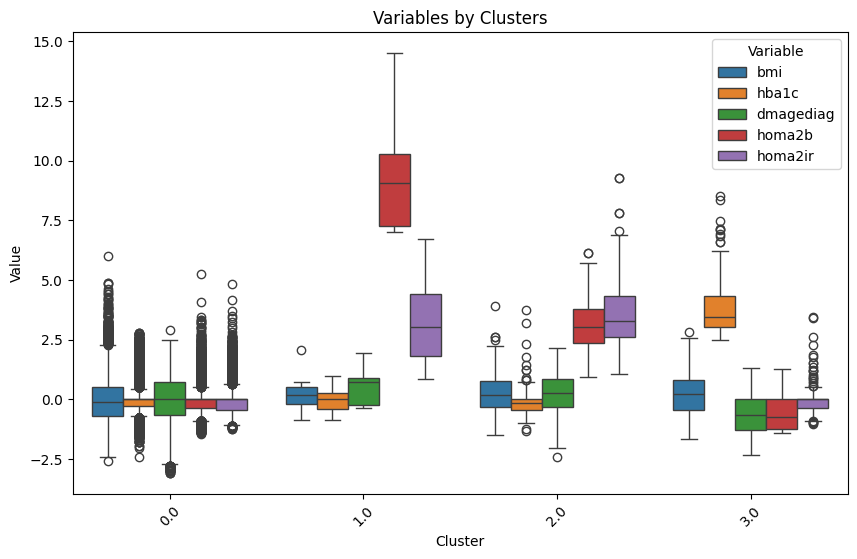

In [30]:
import seaborn as sns
# plot the clusters
# Create a new DataFrame with the cluster assignments and variables
data_clustered = pd.concat([data_filled_cluster['cluster'], data_filled_cluster[['bmi', 'hba1c', 'dmagediag', 'homa2b', 'homa2ir']]], axis=1)

# Melt the DataFrame to convert it into long format
data_melted = data_clustered.melt(id_vars='cluster', var_name='Variable', value_name='Value')

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='Value', hue='Variable', data=data_melted)
plt.title('Variables by Clusters')
plt.xlabel('Cluster')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.show()


### Now try the KPOD with the Scaled data with imputated values 

In [17]:
# Convert back to numpy array for k-means
data_filled = imputed_df.values

# Run k-POD clustering
clustered_data = k_pod(data_filled, n_clusters)

# Get the results
cluster_assignments = clustered_data[0]
cluster_centers = clustered_data[1]

print("Final Cluster Labels:\n", cluster_assignments)
print("Final Centroids:\n", cluster_centers)

Final Cluster Labels:
 [0. 0. 0. ... 0. 0. 0.]
Final Centroids:
 [array([-0.00923781, -0.07134261,  0.00707231, -0.05536849, -0.0688806 ]), array([0.2685784 , 0.02435175, 0.55562023, 9.35725892, 3.2742618 ]), array([ 0.27723722, -0.105843  ,  0.21465054,  3.18246998,  3.58522291]), array([ 0.21045026,  3.90617557, -0.61403839, -0.61716326,  0.03416558])]


In [18]:
# add the cluster assignments to the data_filled
data_filled_cluster = data_filled.copy()
data_filled_cluster = pd.DataFrame(data_filled_cluster, columns = ['bmi', 'hba1c', 'dmagediag','homa2b','homa2ir'])
data_filled_cluster['cluster'] = cluster_assignments
# check sample size in each cluster
print(data_filled_cluster['cluster'].value_counts())


cluster
0.0    8107
3.0     152
2.0     147
1.0       8
Name: count, dtype: int64


In [19]:
# check the varaibles in each cluster
data_filled_cluster.groupby('cluster').mean()


,bmi,hba1c,dmagediag,homa2b,homa2ir
cluster,,,,,
0.0,-0.009238,-0.071343,0.007072,-0.055368,-0.068881
1.0,0.268578,0.024352,0.555620,9.357259,3.274262
2.0,0.277237,-0.105843,0.214651,3.182470,3.585223
3.0,0.210450,3.906176,-0.614038,-0.617163,0.034166


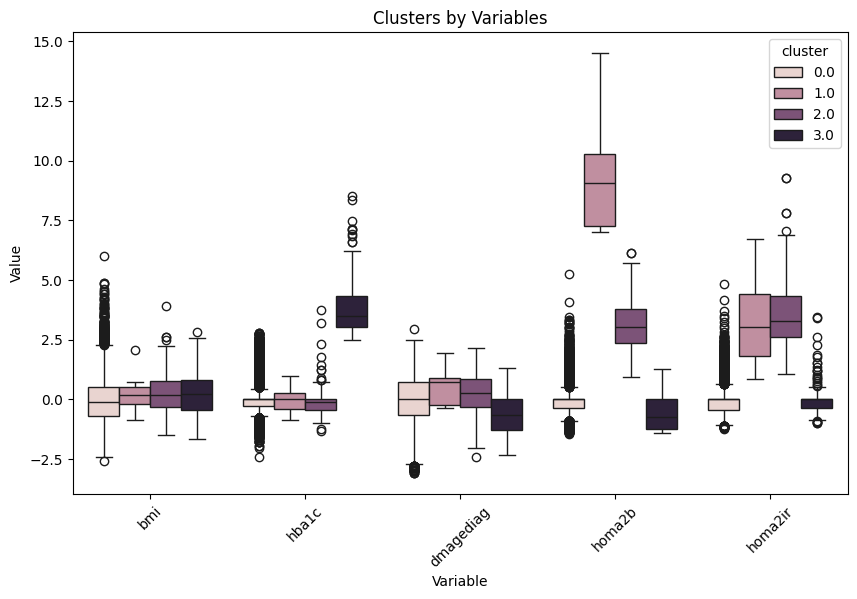

In [22]:
import seaborn as sns

# # Create a new DataFrame with the cluster assignments and variables
data_clustered = pd.concat([data_filled_cluster['cluster'], data_filled_cluster[['bmi', 'hba1c', 'dmagediag', 'homa2b', 'homa2ir']]], axis=1)

# Melt the DataFrame to convert it into long format
data_melted = data_clustered.melt(id_vars='cluster', var_name='Variable', value_name='Value')

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Variable', y='Value', hue='cluster', data=data_melted)
plt.title('Clusters by Variables')
plt.xlabel('Variable')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.show()


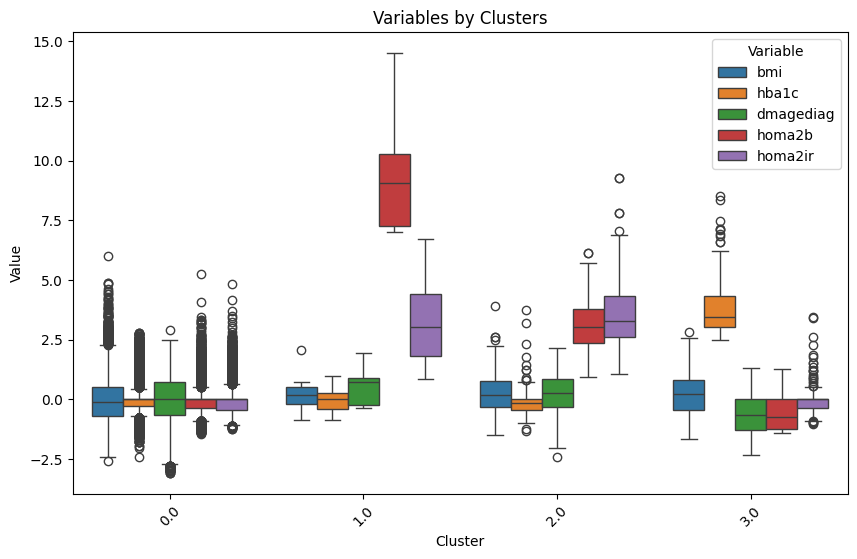

In [31]:
import seaborn as sns

# Create a new DataFrame with the cluster assignments and variables
data_clustered = pd.concat([data_filled_cluster['cluster'], data_filled_cluster[['bmi', 'hba1c', 'dmagediag', 'homa2b', 'homa2ir']]], axis=1)

# Melt the DataFrame to convert it into long format
data_melted = data_clustered.melt(id_vars='cluster', var_name='Variable', value_name='Value')

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='Value', hue='Variable', data=data_melted)
plt.title('Variables by Clusters')
plt.xlabel('Cluster')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.show()


